# Setup DevCloud environment

1. Create DevCloud account

2. Access via unique access URL: In your welcome Email. You might want to save the link for future access.

3. Copy exercises by launching a Terminal:

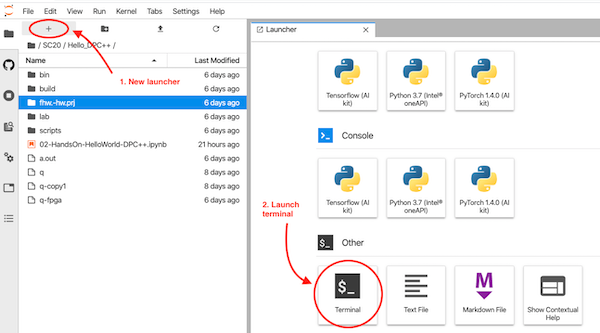

Type the following command in your Terminal

``$ /data/oneapi_workshop/get_sc20_tutorial.sh``

You're all set. Next task: get familiar with the programming environment

### Optional: Other things to try for more examples

Open a Terminal and type:

``$ oneapi-cli``

To get access to more oneAPI code examples and Tutorials. 

Or simply launch the following cell to get access to the example James shared in the first session:

In [ ]:
! cd ~; wget tinyurl.com/tut116-code; tar xvfz tut116-code

# Introduction to DPC++

##### Sections
- _Code_: [Hello, DPC++!](#Hello,-DPC++!)
- _Code_: [Targeting an FPGA](#Targeting-an-FPGA)

# Hello, DPC++!

To begin, we'll build and run a very simple Data Parallel C++ code example. Our first example adds two vectors A and B, and stores the result in a third vector C. The additions of vector elements can be interleaved and executed in parallel, since there are no dependencies between iterations. A kind of hello world example of data parallel programming, isn't it?

Inspect the code below - there are no modifications necessary. Run the first cell to create the file, then run the cell below it to compile and execute the code.
1. Inspect the code cell below, then click run ▶ to save the code to a file
2. Run ▶ the cell in the __Build and Run__ section below the code snippet to compile and execute the code in the saved file

In [ ]:
%%writefile lab/vector-add.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
#define SIZE 1024

using namespace cl::sycl;

int main() {
  std::array<int, SIZE> a, b, c;
  for (int i = 0; i<SIZE; ++i) {
    a[i] = i + 1;
    b[i] = -i;
    c[i] = 0;
  }
  {
    range<1> r{SIZE};
    queue q;
    buffer<int, 1> a_buf(a.data(), r);
    buffer<int, 1> b_buf(b.data(), r);
    buffer<int, 1> c_buf(c.data(), r);
    q.submit([&](handler &h) {
      accessor a(a_buf, h, read_only);
      accessor b(b_buf, h, read_only);
      accessor c(c_buf, h, write_only);
      h.parallel_for(r,[=](id<1> idx) {
        c[idx] = a[idx] + b[idx];
      });
    }).wait();
  }
  std::cout << "DONE.\n";
  return 0;
}

In [ ]:
%%writefile scripts/run_vector_add.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling DPC++ example
rm -rf bin/vector-add
dpcpp lab/vector-add.cpp -o bin/vector-add
bin/vector-add

Select the cell below and click Run ▶ to compile and execute the code above:

In [ ]:
! chmod 755 q; chmod 755 ./scripts/run_vector_add.sh; if [ -x "$(command -v qsub)" ]; then ./q scripts/run_vector_add.sh; else ./scripts/run_vector_add.sh; fi

__Alternatively__, you can split the compilation and execution step, by using the following two separate commands:

In [ ]:
! dpcpp lab/vector-add.cpp -o bin/vector-add

In [ ]:
! qsub -l nodes=1:ppn=2:gpu -d . scripts/run_vector_add.sh

The output is written to a file ``run_vector_add.sh.oXXXXXX`` that should appear within seconds in the file browser on the left hand side.

In [ ]:
! cat run_vector_add.sh.*; rm run_vector_add.sh.*

# Targeting an FPGA

Before we practice how to use a device selector and buffers in the next Hands-on session.
In the last exercise for this session, we will do some prework for the next session: FPGA programming with DPC++. 

The final compilation step of DPC++ application for target FPGA can take several hours, which means our coffee break is not sufficient to run the compilation. What we want to do is start it now, so we have it ready later. After learning what we have actually compiled. So, no worries if you don't fully understand the following code example. 

The example is using a vendor specific device selector, which is required to trigger the ahead of time compilation.

In [ ]:
%%writefile lab/vector-add-fpga.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
#include <CL/sycl/INTEL/fpga_extensions.hpp>

#define SIZE 1024

using namespace sycl;

int main() {
    
    {
        range<1> r{SIZE};
        #ifdef FPGA_EMULATOR
        INTEL::fpga_emulator_selector device_selector;
        #else
        INTEL::fpga_selector device_selector;
        #endif
        queue q(device_selector);
        
        buffer<int, 1> a_buf{r};
        buffer<int, 1> b_buf{r};
        buffer<int, 1> c_buf{r};
    
    // a ---- c --- d
    // b __/   
    
        q.submit([&](handler& h) {
            accessor a(a_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                a[idx] = idx; }); 
        });
        q.submit([&](handler& h) {
            accessor b(b_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                b[idx] = -idx; }); 
        });
        q.submit([&](handler& h) {
            accessor a(a_buf, h, read_only);
            accessor b(b_buf, h, read_only);
            accessor c(c_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                c[idx] = a[idx] + b[idx]; }); 
        });
        q.submit([&](handler& h) {
            accessor c(c_buf, h, read_write);
            h.parallel_for(r, [=](auto idx) {
                c[idx] += 1; }); 
        }).wait();
    }
    std::cout << "DONE.\n";
    
    return 0;
}

In [ ]:
%%writefile scripts/compile_fpga_hw.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh
rm -rf bin/fpga-hw.o
#/bin/echo "##" $(whoami) is compiling DPC++ example for FPGA hardware
dpcpp -fintelfpga -c lab/vector-add-fpga.cpp -o bin/fpga-hw.o
dpcpp -fintelfpga bin/fpga-hw.o -Xshardware -Xsboard=intel_a10gx_pac:pac_a10 -Xsparallel=8 -o bin/fpga-hw

Select the cell below and click Run ▶ to compile the code above:

In [ ]:
!qsub -l nodes=1:ppn=2:fpga_compile -d . scripts/compile_fpga_hw.sh


You'll notice when the enqueued job finishes because you'll see two new files in this directory: `compile_fpga_hw.sh.e<number>` and `compile_fpga_hw.sh.o<number>`. The `.e` is the error file and if everything went well, it should be empty. The `.o` will have the messages issues by the dpcpp compiler (you may find warnings, for example). 

### Note: Skip the next steps in this section for now and jump right to compiling an [FPGA kernel!](#Compile-an-FPGA-kernel-that-we-will-link-with-a-host-code-tomorrow)

Once the compilation has been finished, and if you are on a node equipped with an FPGA, you can run the code on the FPGA using the following command:


In [ ]:
! cat compile_fpga_hw.sh.*; rm compile_fpga_hw.sh.*

In [ ]:
! bin/fpga-hw

If the previous execution failed with a `CL_DEVICE_NOT_FOUND` message, you are not running this code on a node with a FPGA. But you can submit the executable to such a node building a script like this:

In [ ]:
%%writefile scripts/launch_fpga_code.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is launching fpga-hw code
bin/fpga-hw

And now we can enqueue it to the right node

In [ ]:
!qsub -l nodes=1:ppn=2:fpga -d . scripts/launch_fpga_code.sh

Once you see the .e and .o files apearing on the File Browser on the left, you can do this:

In [ ]:
!cat launch_fpga_code.sh.*; rm launch_fpga_code.sh.*

# Compile an FPGA kernel that we will link with a host code tomorrow

Since FPGA compilation can take some hours, we can compile today an FPGA kernel that sits in a separate file. Tomorrow we will link the resulting object with the host code to get the executable.

In [ ]:
!mkdir FPGA_kernel

In [ ]:
%%writefile FPGA_kernel/kernel.hpp
//==============================================================
// Copyright Intel Corporation
//
// SPDX-License-Identifier: MIT
// =============================================================
#include <CL/sycl.hpp>
using namespace sycl;

// tolerance used in floating point comparisons
constexpr float kTol = 0.001;

// array size of vectors a, b and c
constexpr size_t array_size = 32;

void RunKernel(std::vector<float> &a_array, std::vector<float> &b_array,
               std::vector<float> &c_array, float alpha);

In [ ]:
%%writefile FPGA_kernel/kernel.cpp
//==============================================================
// Copyright Intel Corporation
//
// SPDX-License-Identifier: MIT
// =============================================================

// Header locations and some DPC++ extensions changed between beta09 and beta10
// Temporarily modify the code sample to accept either version
#include <CL/sycl.hpp>
#define BETA09 20200827
#if __SYCL_COMPILER_VERSION <= BETA09
  #include <CL/sycl/intel/fpga_extensions.hpp>
  namespace INTEL = sycl::intel;  // Namespace alias for backward compatibility
#else
  #include <CL/sycl/INTEL/fpga_extensions.hpp>
#endif

// dpc_common.hpp can be found in the dev-utilities include folder.
// e.g., $ONEAPI_ROOT/dev-utilities/latest/include/dpc_common.hpp
#include "dpc_common.hpp"

#include "kernel.hpp"

// Forward declaration of the kernel name
// (This will become unnecessary in a future compiler version.)
class VectorAdd;

void RunKernel(std::vector<float> &a_array, std::vector<float> &b_array,
               std::vector<float> &c_array, float alpha) {

  // Select either the FPGA emulator or FPGA device
#if defined(FPGA_EMULATOR)
  INTEL::fpga_emulator_selector device_selector;
#else
  INTEL::fpga_selector device_selector;
#endif

  try {

    // Create a queue bound to the chosen device.
    // If the device is unavailable, a SYCL runtime exception is thrown.
    queue q(device_selector, dpc_common::exception_handler);

    // Print out the device information.
    std::cout << "Running on device: "
              << q.get_device().get_info<info::device::name>() << "\n";

    // Device buffers
    buffer device_a(a_array);
    buffer device_b(b_array);
    // Use verbose SYCL 1.2 syntax for the output buffer.
    // (This will become unnecessary in a future compiler version.)
    buffer<float, 1> device_c(c_array.data(), array_size);

    q.submit([&](handler &h) {
      // Data accessors
      auto a = device_a.get_access<access::mode::read>(h);
      auto b = device_b.get_access<access::mode::read>(h);
      auto c = device_c.get_access<access::mode::discard_write>(h);

      // Kernel executes with pipeline parallelism on the FPGA.
      // Use kernel_args_restrict to specify that a, b, and r do not alias.
      h.single_task<VectorAdd>([=]() [[intel::kernel_args_restrict]] {
        for (size_t i = 0; i < array_size; ++i) {
          c[i] = a[i] + b[i] * alpha;
        }
      });
    }).wait();

  } catch (sycl::exception const &e) {
    // Catches exceptions in the host code
    std::cout << "Caught a SYCL host exception:\n" << e.what() << "\n";

    // Most likely the runtime couldn't find FPGA hardware!
    if (e.get_cl_code() == CL_DEVICE_NOT_FOUND) {
      std::cout << "If you are targeting an FPGA, please ensure that your "
                   "system has a correctly configured FPGA board.\n";
      std::cout << "If you are targeting the FPGA emulator, compile with "
                   "-DFPGA_EMULATOR.\n";
    }
    std::terminate();
  }
}


In [ ]:
%%writefile FPGA_kernel/compile.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
rm -rf dev_image.a dev.o
/bin/echo "##" $(whoami) is compiling a DPC++ kernel for FPGA hardware
dpcpp -fintelfpga -c kernel.cpp -o dev.o
dpcpp -fintelfpga -Xshardware -Xsboard=intel_a10gx_pac:pac_a10 -fsycl-link=image dev.o -o dev_image.a
/bin/echo "##" Compilation finished!

In [ ]:
!qsub -lnodes=1:ppn=2:fpga_compile -d FPGA_kernel FPGA_kernel/compile.sh

# Some hours later (or tomorrow)...

We will see the .e and .o files

In [ ]:
!cat FPGA_kernel/compile.sh.*; rm FPGA_kernel/compile.sh.*

In [ ]:
!ls -la FPGA_kernel

Note that the kernel.o has been generated. Now we can compile and link with the host code:

In [ ]:
%%writefile FPGA_kernel/main.cpp
//==============================================================
// Copyright Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
#include <iomanip>
#include <iostream>
#include <vector>
#include <tbb/blocked_range.h>
#include <tbb/parallel_for.h>
#include "tbb/task_group.h"

#include "kernel.hpp"

using namespace sycl;

int main() {

  const float alpha = 0.5;  // coeff for triad calculation

  std::vector<float> a_array(array_size);
  std::vector<float> b_array(array_size);
  std::vector<float> c_sycl(array_size);
  std::vector<float> c_tbb(array_size);

  // Fill vectors a and b with random float values
  for (size_t i = 0; i < array_size; i++) {
    a_array[i] = rand() / (float)RAND_MAX;
    b_array[i] = rand() / (float)RAND_MAX;
  }

  // create task_group
  tbb::task_group tg;

  // Run a TBB task that uses SYCL to offload to FPGA, function run does not block
  tg.run([&, alpha]() {
    std::cout << "executing on the FPGA using SYCL\n";
    // The definition of this function is in a different compilation unit,
    // so host and device code can be separately compiled.
    RunKernel(a_array, b_array, c_sycl, alpha);
  });

  // Run a TBB task that uses SYCL to run in parallel on the CPU
  tg.run([&, alpha]() {
    std::cout << "executing on the CPU using TBB\n";

    tbb::parallel_for(tbb::blocked_range<int>(0, a_array.size()),
      [&](tbb::blocked_range<int> r) {
        for (int index = r.begin(); index < r.end(); ++index) {
          c_tbb[index] = a_array[index] + b_array[index] * alpha;
        }
    });
  });

  // wait for both TBB tasks to complete
  tg.wait();

  // Test the results
  size_t correct = 0;
  for (size_t i = 0; i < array_size; i++) {
    float tmp = c_tbb[i] - c_sycl[i];
    if (tmp * tmp < kTol * kTol) {
      correct++;
    }
  }

  // Summarize results
  if (correct == array_size) {
    std::cout << "PASSED: results are correct\n";
  } else {
    std::cout << "FAILED: results are incorrect\n";
  }

  return !(correct == array_size);
}


In [ ]:
!dpcpp -fintelfpga FPGA_kernel/main.cpp -c -o FPGA_kernel/host.o

In [ ]:
!dpcpp -fintelfpga FPGA_kernel/host.o FPGA_kernel/dev_image.a -o FPGA_kernel/main -tbb -lpthread

Psst, feel free to modify anything in the main.cpp code and recompile and link again ... this is fast as long as you don't modify the kernel.cpp

In [ ]:
%%writefile scripts/launch_fpga_code.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is launching main code
FPGA_kernel/main

And now we can enqueue it to the right node

In [ ]:
!qsub -l nodes=1:ppn=2:fpga -d . scripts/launch_fpga_code.sh

Once you see the .e and .o files apearing on the File Browser on the left, you can do this:

In [ ]:
!cat launch_fpga_code.sh.*; rm launch_fpga_code.sh.*

You are all set!